<a href="https://colab.research.google.com/github/SergeiSa/Control-Theory-Slides-Spring-2022/blob/main/Assignment/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stabilization of Cart Pole system**: 
> Consider cart pole system:
>
>
><p><img alt="mbk" height="250px" src="https://drive.google.com/uc?id=1O1iM6MByfMyrO0txAMFb_miOqPNzFAvm" align="center" hspace="350px" vspace="0px"></p>
>
>
> Do the following:
>*   1) Design the linear feedback controller using linearization of the cart-pole dynamics.
>*   2) Simulate the response of your controller on the linearized and nonlinear system, compare the results.
>*   3) Taking into account that $y = Cx$ is measured, design observer and linear control that uses observer state. 
>*   4) Simulate the nonlinear system with the observer and controller, show the difference between the actual motion of the nonlinear system and its estimate produced by the observer.
>
> [Here is the great illustration of the hardware implemintation of the cart-pole](https://www.youtube.com/shorts/NJxBJ2LJY7w) 


In [3]:
import sympy as sp
sp.init_printing()


# sympy rounding for expressions
# source: https://stackoverflow.com/a/60284977
def round_expr(expr, num_digits=2):
    return expr.xreplace({n.evalf(): n if type(n) == int else sp.Float(n, num_digits) for n in expr.atoms(sp.Number)})


## **System Dynamics**: 

Recall the dynamics of cart-pole system:
$$
\begin{cases} 
\left(M+m\right){\ddot {p}}-m L \ddot{\theta} \cos \theta +m L \dot{\theta }^{2}\sin \theta = u \\
L \ddot{\theta}- g\sin \theta =\ddot{p} \cos \theta  \\
\end{cases}
$$

where $\theta$ is angle of the pendulum measured from the upper equilibrium and $p$ is position of cart


Choosing the state to be $\mathbf{x} = [\theta, \dot{\theta}, p, \dot{p}]^T$ One may rewrite this dynamics in the state-space form as:
$$
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ 
\ddot{\theta} \\ 
\dot{p} \\ 
\ddot{p}
\end{bmatrix} 
= 
\begin{bmatrix}
\dot{\theta} \\ 
\frac{(M+m)g \sin \theta - mL \dot{\theta}^2 \sin\theta \cos\theta}{(M + m\sin^2 \theta)L} \\ 
\dot{p} \\ 
\frac{mg\sin\theta \cos\theta - mL\dot{\theta}^2 \sin \theta}{M + m\sin^2 \theta} \\ 
\end{bmatrix} 
+
\begin{bmatrix}
0 \\ 
\frac{\cos\theta}{(M + m\sin^2 \theta)L} \\ 
0 \\ 
\frac{1}{M + m\sin^2 \theta} \\ 
\end{bmatrix} u
$$


### **System parameters**: 
Let us choose the following parameters:

In [4]:
m = 0.5  # mass of pendulum bob
M = 2  # mass of cart
pendulumn_length = 0.3  # length of pendulum
g = 9.81  # gravitational acceleration


#### **Nonlinear dynamics**: 

First of all let us define the nonlinear system in form $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})$ :

In [5]:
import numpy as np
from math import cos, sin
import matplotlib.pyplot as plt

# Nonlinear cart-pole dynamics


def func(x, u):
    theta, dtheta, p, dp = x
    u = u[0]

    denominator = M + m*(sin(theta)**2)
    ddtheta = ((M + m)*g*sin(theta) - m * pendulumn_length * dtheta**2 *
               sin(theta) * cos(theta) + cos(theta)*u)/(denominator * pendulumn_length)
    ddp = (m*g*sin(theta)*cos(theta) - m * pendulumn_length *
           dtheta**2 * sin(theta) + u)/denominator

    dx = np.array([dtheta, ddtheta, dp, ddp])
    return dx


x0 = np.array([1,  # Initial pendulum angle
               0,  # Initial pendulum angular speed
               1,  # Initial cart position
               0])  # Initial cart speed
u0 = np.array([0])
print(func(x0, u0))


[ 0.         29.22225161  0.          0.947331  ]


### **Linearized Dynamics**: 

Liniarization around the upper equilibrium $\mathbf{x} = [0,0,0,0]$ yields:

\begin{equation}
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ 
\ddot{\theta} \\ 
\dot{p} \\ 
\ddot{p}
\end{bmatrix} 
=
\begin{bmatrix}
0 & 1 & 0 & 0\\
\frac{(M+m)}{M}\frac{g}{L} & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\frac{m}{M}g & 0 & 0 & 0 
\end{bmatrix} 
\begin{bmatrix}
\theta \\ 
\dot{\theta} \\ 
p \\ 
\dot{p}
\end{bmatrix} 
+
\begin{bmatrix}
0 \\
\frac{1}{ML} \\
0 \\
\frac{1}{M}
\end{bmatrix}
u
\end{equation}

In [28]:
# System matrix
A = np.array([[0, 1, 0, 0],
             [(M + m)*g / (M*pendulumn_length), 0, 0, 0],
             [0, 0, 0, 1],
             [m*g/M, 0, 0, 0]])
# Input matrix
B = np.array([[0],
             [1/(M*pendulumn_length)],
             [0],
             [1/M]])
C = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])


### **Controller Design**: 

Let us design the controller for linearized plant by placing poles (eigen values) on the left-hand side of complex plane:


Check eigenvalues of the closed-loop system for:
1. closed-loop for the case when full state information is availible and no observer is used
2. when only measurement $y = Cx$ is availible and an observer is used

In [73]:
# Control design using pole placement method
from scipy.signal import place_poles as pp
from numpy.linalg import eigvals as eig
P = [-1, -2, -3, -4]
K = pp(A, B, P).gain_matrix
print(round_expr(sp.Matrix(K)), eig(A - B @ K))


Matrix([[46., 6.9, -1.5, -3.1]]) [-4. -3. -2. -1.]


Eigenvalues of the closed-loop system for the 1st case (without observer): $\mathbf{\lambda} = \left[\begin{matrix}-4.0\\-3.0\\-2.0\\-1.0\end{matrix}\right]$

Control law is following: $\mathbf{u} = -\begin{bmatrix}46 & 6.9 & -1.5 & -3.1\end{bmatrix}\mathbf{x}$

In [47]:
# Observer design using LQR method
from scipy.linalg import solve_continuous_are as are
from numpy.linalg import inv
from control import lqr
Q = np.array([[1, 0, 0, 0],
              [0, 2, 0, 0],
              [0, 0, 3, 0],
              [0, 0, 0, 4]])
R = np.eye(3) * 10

S = are(A.T, C.T, Q, R).T
L = (inv(R) @ C @ S).T  # feedback gain observer
eigs = eig(A.T - C.T @ L.T)
print("Solution S of Riccati equation: ", S)
print("State feedback gain observer L: ", L)
print("Eigenvalues of the system: ", eigs)

print("Check with LQR method from control library:")
L_c, S_c, eigs_c = lqr(A.T, C.T, Q, R)
print("S check ", S_c.all() == S.all())
print("L check ", L_c.T.all() == L.all())
print("Eigs check ", eigs_c.all() == eigs.all())


Solution S of Riccati equation:  [[  3.24024881  19.97390014   0.14867288   1.18757799]
 [ 19.97390014 126.28853178   0.95572902   7.48648873]
 [  0.14867288   0.95572902  12.52210177   6.38692772]
 [  1.18757799   7.48648873   6.38692772   8.36631716]]
State feedback gain observer L:  [[ 0.32402488  1.99739001  0.01486729]
 [ 1.99739001 12.62885318  0.0955729 ]
 [ 0.01486729  0.0955729   1.25221018]
 [ 0.1187578   0.74864887  0.63869277]]
Eigenvalues of the system:  [-6.47677329+0.96111483j -6.47677329-0.96111483j -0.62577083+0.49136506j
 -0.62577083-0.49136506j]
Check with LQR method from control library:
S check  True
L check  True
Eigs check  True


Eigenvalues of the closed-loop system for the 2nd case (with observer): $\lambda = \begin{bmatrix}-6.5 + 0.96 i\\-6.5 - 0.96 i\\-0.63 + 0.49 i\\-0.63 - 0.49 i\end{bmatrix}$

State feedback gains observer: $ L = \begin{bmatrix}0.32 & 2.0 & 0.015 & 0.12\\2.0 & 13.0 & 0.096 & 0.75\\0.015 & 0.096 & 1.3 & 0.64\end{bmatrix}$


## **Simulation**:
We proceed with the simulation of designed controller, firstly we will define the simulation parameters: 

In [96]:
# Time settings
t0 = 0  # Initial time
tf = 10  # Final time
N = 1000  # Numbers of points in time span
t = np.linspace(t0, tf, N)  # Create time span

# Define initial point
theta_0 = 0.4
p_0 = 0.1

# Set initial state
x0 = np.array([theta_0,  # Initial pendulum angle
               0,  # Initial pendulum angular speed
               p_0,  # Initial cart position
               0])  # Initial cart speed
# Set initial observer state
observer_coefficient = 7  # randomly chosen by me :)
x_hat0 = x0 * observer_coefficient


#### **Linearized dynamics**: 
Now let us simulate the response of linear controller on the **linearized** system:

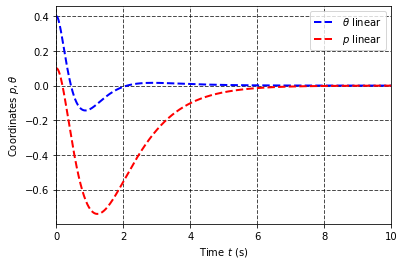

In [40]:
# import integrator routine
from scipy.integrate import odeint

# Define the linear ODE to solve


def linear_ode(x, t, A, B, K):
    # Linear controller
    u = - np.dot(K, x)
    # Linearized dynamics
    dx = np.dot(A, x) + np.dot(B, u)
    return dx


# integrate system "sys_ode" from initial state $x0$
x_l = odeint(linear_ode, x0, t, args=(A, B, K,))
theta_l, dtheta_l, p_l, dp_l = x_l[:, 0], x_l[:, 1], x_l[:, 2], x_l[:, 3]
# Plot the resulst
plt.plot(t, theta_l, 'b--', linewidth=2.0, label=r'$\theta$ linear')
plt.plot(t, p_l, 'r--', linewidth=2.0, label=r'$p$ linear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()


Now we will simulate similarly to linear case while using the same gains $\mathbf{K}$:

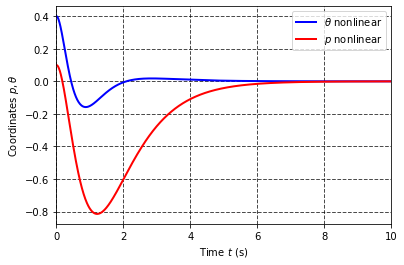

In [42]:
def nonliear_ode(x, t, K):

    # Linear controller
    u = - np.dot(K, x)
    # u = np.array([0])

    # Nonlinear dynamics
    dx = func(x, u)

    return dx


# integrate system "sys_ode" from initial state $x0$
x_nl = odeint(nonliear_ode, x0, t, args=(K,))
theta_nl, dtheta_nl, p_nl, dp_nl = x_nl[:,
                                        0], x_nl[:, 1], x_nl[:, 2], x_nl[:, 3]
# Plot the resulst
plt.plot(t, theta_nl, 'b', linewidth=2.0, label=r'$\theta$ nonlinear')
plt.plot(t, p_nl, 'r', linewidth=2.0, label=r'$p$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()


### Simulation with observer

Insert your code simulating the behaviour of the nonlinear system with an observer. Plot the results, compare state estimatio and actual state of the system.

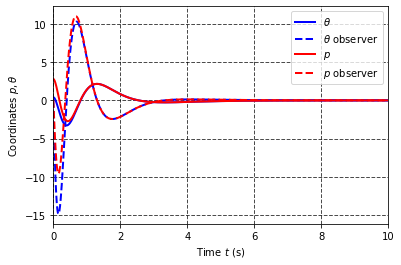

In [108]:
from scipy.integrate import odeint


def observer_ode(state, t, A, B, C, K, L):
    x, x_hat = np.split(state, 2)

    u = - K @ x_hat
    dx = A @ x + B @ u

    y = C @ x
    y_hat = C @ x_hat
    e = y - y_hat

    dx_hat = A @ x_hat + B @ u + L @ e

    dstate = np.hstack((dx, dx_hat))
    return dstate


state0 = np.hstack((x0, x_hat0))

# integrate system "sys_ode" from initial state $state0$
state_sol = odeint(observer_ode, state0, t, args=(A, B, C, K, L, ))

theta_o, dtheta_o, p_o, dp_o = np.split(state_sol, 4, axis=1)

# Plot the resulst
plt.plot(t, theta_o[:, 0], 'b', linewidth=2.0, label=r'$\theta$')
plt.plot(t, theta_o[:, 1], 'b--', linewidth=2.0, label=r'$\theta$ observer')
plt.plot(t, p_o[:, 0], 'r', linewidth=2.0, label=r'$p$')
plt.plot(t, p_o[:, 1], 'r--', linewidth=2.0, label=r'$p$ observer')
# plt.plot(t, dtheta_o[:, 0], 'g', linewidth=2.0, label=r'$d\theta$')
# plt.plot(t, dtheta_o[:, 1], 'g--', linewidth=2.0, label=r'$d\theta$ observer')
# plt.plot(t, dp_o[:, 0], 'y', linewidth=2.0, label=r'$dp$')
# plt.plot(t, dp_o[:, 1], 'y--', linewidth=2.0, label=r'$dp$ observer')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()


So, we can see the big difference between controller and observer states at the beginning. Nevertheless, the system stabilizes at the same time from controller and observer side.

### **Comparison**: 
One may compare the linear and nonlinear responses by plotting them together:

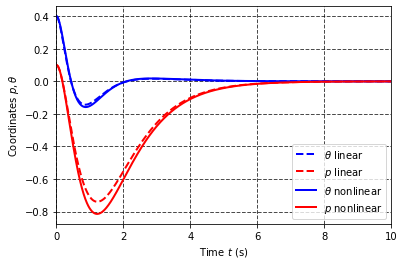

In [87]:
# theta_l, p_l - values of theta and p for the linear system
# theta_nl, p_nl - values of theta and p for the nonlinear system

plt.plot(t, theta_l, 'b--', linewidth=2.0, label=r'$\theta$ linear')
plt.plot(t, p_l, 'r--', linewidth=2.0, label=r'$p$ linear')
plt.plot(t, theta_nl, 'b', linewidth=2.0, label=r'$\theta$ nonlinear')
plt.plot(t, p_nl, 'r', linewidth=2.0, label=r'$p$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()


# **Animation**

In [109]:
# p = p_nl
# theta = theta_nl

# System with observer:
p = p_o[:, 0]
theta = theta_o[:, 0]

time = t


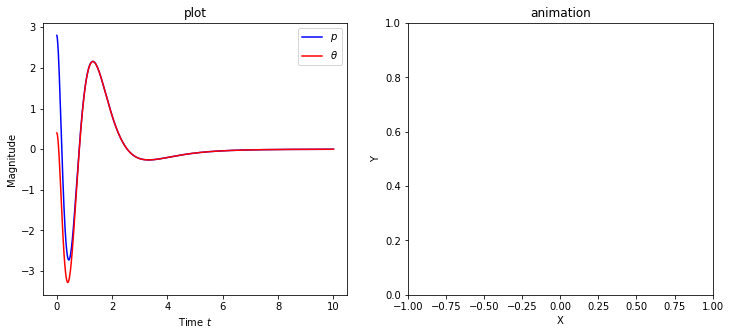

In [121]:
%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# set up the subplots as needed
# ax1.set_xlim(( 0, 2))
# ax1.set_ylim((-0.3, 0.3))
ax1.set_xlabel(r'Time $t$')
ax1.set_ylabel('Magnitude')

ax2.set_xlim((-1, 1))
ax2.set_ylim((0, 1))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('animation')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('plot')
# ax.plot returns a list of 2D line objects
line_x,     = ax1.plot(time, p, 'b', label=r'$p$')
line_theta, = ax1.plot(time, theta, 'r', label=r'$\theta$')
point_x,     = ax1.plot([], [], 'g.', ms=20)
point_theta, = ax1.plot([], [], 'g.', ms=20)

draw_cart,  = ax2.plot([], [], 'b', lw=2)
draw_shaft, = ax2.plot([], [], 'r', lw=2)

ax1.legend()


In [122]:

shaft_l = 0.3
cart_l = 0.1
cart_x = np.array([-1, -1, 1, 1, -1])*cart_l
cart_y = np.array([0,  1, 1, 0,  0])*cart_l


# animation function. This is called sequentially
def drawframe(n):

    shaft_x = np.array([p[n],  p[n] + shaft_l*sin(theta[n])])
    shaft_y = np.array([cart_l/2,  cart_l/2 + shaft_l*cos(theta[n])])

    line_x.set_data(time, p)
    line_theta.set_data(time, theta)

    point_x.set_data(time[n], p[n])
    point_theta.set_data(time[n], theta[n])

    draw_cart.set_data(cart_x+p[n], cart_y)
    draw_shaft.set_data(shaft_x, shaft_y)

    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (draw_cart, draw_shaft)


In [123]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(
    fig, drawframe, frames=500, interval=20, blit=True)


## Here we try to make a video of the cart-pole as it moves

In [126]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [124]:
# The solution for animation video due to bug in VSCode jupyter extension
index = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Cart-pole animation</title>
</head>
<body>"""

videoHTML = anim.to_html5_video()

index += videoHTML

index += """      
</body>
</html>
"""
with open('index.html', 'w') as f:
    f.write(index)
